Vanilla GAN from this website

https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/VanillaGAN.ipynb

https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/Conditional-GAN.ipynb


Combine into a DCGAN - 1D

https://github.com/LixiangHan/GANs-for-1D-Signal/blob/main/dcgan.py



In [1]:
#!pip install torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
!pip install torchinfo
from torchinfo import summary


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torch.autograd as autograd

In [4]:
import numpy as np
import datetime
import os, sys
import scipy.io
import scipy.fftpack
from numpy.fft import fft, ifft

In [5]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
MODEL_NAME = 'ConditionalWGAN'
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
def to_onehot(x, num_classes=2):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [8]:
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    #img = np.zeros([280, 280])
    for j in range(2):
        c = torch.zeros([10, 2]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(DEVICE) # number of random noise vectors created = 10
        y_hat = G(z,c).view(10, 1, 1000)
        #result = y_hat.cpu().data.numpy()
        if j == 0: # this is a left movement
          data_left = y_hat.cpu().data.numpy()
        else:
          data_right = y_hat.cpu().data.numpy()
    return data_left, data_right

In [9]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, in_channel=1, input_size = 1000, num_classes=2):
        super(Discriminator, self).__init__()
        self.transform = nn.Sequential(
            nn.Linear(input_size + num_classes, 1000),
            nn.LeakyReLU(0.2),
        )

        self.conv = nn.Sequential(
            nn.Conv1d(in_channel, 1024, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv1d(1024, 512, kernel_size=3, stride=3, padding=1, bias=False),
            #nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # state size 456
            nn.Conv1d(512, 256, kernel_size=3, stride=3, padding=1, bias=False),
            #nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),


            # state size 228
           nn.Conv1d(256, 128, kernel_size=4, stride=4, padding=1, bias=False),
           #nn.BatchNorm1d(64),
           nn.LeakyReLU(0.2, inplace=True),
           nn.AvgPool1d(6),
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 1),
            #nn.Sigmoid(),
        )

    def forward(self, x, c=None):
        # x: (N, 3, 1000), c: (N, 2)
        x, c = x.view(x.size(0), -1), c.float() #c: (N, channels, input), c: (N, num_classes)
        v = torch.cat((x, c), 1) # (n, 3002) adding embedding
        #print(v.shape)
        y_ = self.transform(v) # (N, 3002)
        y_ = y_.view(y_.shape[0], 1 ,1000) # (N, 3, 1000)
       # print(y_.shape)
        y_ = self.conv(y_)
        #print(y_.shape)
        y_ = y_.view(y_.size(0), -1)
        #print(y_.shape)
        y_ = self.fc(y_)
        return y_

In [10]:


# Define model and inputs
model = Discriminator(in_channel=1, input_size=1000, num_classes=2)
batch_size = 16
input_size = (batch_size, 1, 1000)  # Adjust based on your use case
class_label_size = (batch_size, 2)

# Summarize model
summary(
    model,
    input_size=(input_size, class_label_size),
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    depth=3
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Discriminator                            [16, 1, 1000]             [16, 1]                   --                        --                        --
├─Sequential: 1-1                        [16, 1002]                [16, 1000]                --                        --                        --
│    └─Linear: 2-1                       [16, 1002]                [16, 1000]                1,003,000                 --                        16,048,000
│    └─LeakyReLU: 2-2                    [16, 1000]                [16, 1000]                --                        --                        --
├─Sequential: 1-2                        [16, 1, 1000]             [16, 128, 2]              --                        --                        --
│    └─Conv1d: 2-3                       [16, 1, 1000]             [16, 1024, 500]           4,09

In [11]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=100, condition_size=2):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size+condition_size, 256* 5),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            # input: 4 by 4, output: 7 by 7
            nn.ConvTranspose1d(256, 128, 3, stride=5, padding=1, bias=False),
            #nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.ConvTranspose1d(128, 64, 3, stride=5, padding=1, bias=False),
            #nn.BatchNorm1d(64),
            nn.ReLU(),
            # input: 7 by 7, output: 14 by 14
            nn.ConvTranspose1d(64, 32, 3, stride=2, padding=1, bias=False),
            #nn.BatchNorm1d(32),
            nn.ReLU(),
            # input: 14 by 14, output: 28 by 28
            nn.ConvTranspose1d(32, 1, 4, stride=5, padding=2, bias=False),
            nn.Tanh(),
        )

    def forward(self, x, c):
        # x: (N, 100), c: (N, 2)
        x, c = x.view(x.size(0), -1), c.float() # may not need
        #print(x.shape)
        v = torch.cat((x, c), 1) # v: (N, 102)
        #print(v.shape)
        y_ = self.fc(v)
        #print(y_.shape)
        y_ = y_.view(y_.size(0), 256, 5)
        #print(y_.shape)
        y_ = self.conv(y_) # (N, 28, 28)
        return y_

In [12]:

# Define model and inputs
model = Generator(input_size=100, condition_size=2)
batch_size = 16
input_size = (batch_size, 100)  # Adjust based on your use case
class_label_size = (batch_size, 2)

# Summarize model
summary(
    model,
    input_size=(input_size, class_label_size),
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    depth=3
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Generator                                [16, 100]                 [16, 1, 1000]             --                        --                        --
├─Sequential: 1-1                        [16, 102]                 [16, 1280]                --                        --                        --
│    └─Linear: 2-1                       [16, 102]                 [16, 1280]                131,840                   --                        2,109,440
│    └─ReLU: 2-2                         [16, 1280]                [16, 1280]                --                        --                        --
├─Sequential: 1-2                        [16, 256, 5]              [16, 1, 1000]             --                        --                        --
│    └─ConvTranspose1d: 2-3              [16, 256, 5]              [16, 128, 21]             98,30

In [13]:
n_noise = 100

In [14]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [15]:
what_data_to_use = 'SINE_COSINE'

In [16]:
#%cd /content/drive/MyDrive/CS230/GAN/EEG_2B_Data/
list_of_files = ['B0901T.mat', 'B0902T.mat', 'B0903T.mat', 'B0801T.mat', 'B0802T.mat', 'B0803T.mat','B0701T.mat', 'B0702T.mat', 'B0703T.mat',
                  'B0601T.mat', 'B0602T.mat', 'B0603T.mat', 'B0501T.mat', 'B0502T.mat', 'B0503T.mat', 'B0401T.mat', 'B0402T.mat', 'B0403T.mat',
                  'B0301T.mat', 'B0302T.mat', 'B0303T.mat', 'B0201T.mat', 'B0202T.mat', 'B0203T.mat', 'B0101T.mat', 'B0102T.mat', 'B0103T.mat']

if what_data_to_use == 'EEG_All':
  data =  np.empty((1000, 3, 3240)) # empty np array that concatenates all of the trials
  labels = [] #np.empty((3240,1))

  for idx in range(len(list_of_files)):
    target_tmp = scipy.io.loadmat(list_of_files[idx])
    data_tmp = target_tmp['data']
    label_tmp = target_tmp['label']
    data[:,:, idx*120:(idx+1)*120] = data_tmp
    for i in range(len(label_tmp)):
      if label_tmp[i] == 1.0:
        labels.append(0)
      else:
        labels.append(1)

  data = np.transpose(data, (2, 1, 0))
  label = np.array(labels).reshape(3240, 1)
    
elif what_data_to_use == 'EEG_ONE':
    data =  [] # empty np array that concatenates all of the trials
    labels = [] #np.empty((3240,1))
    temps= []
    target_tmp = scipy.io.loadmat(list_of_files[0])
    data_tmp = target_tmp['data']
    label_tmp = target_tmp['label']
    
    constant_right = data_tmp[:, 0, 0]
    constant_left = data_tmp[:, 0, 1]
    for i in range(3240): 
        indicator = np.random.randint(0,2)
        for j in range(3): 
            if indicator == 0: #left movement 
                temps.append(constant_left)
                if j == 0: 
                    labels.append(0)
            else: 
                temps.append(constant_right)
                if j ==0: 
                    labels.append(1)

    data = np.array(temps).reshape(3240,3,1000) 
    label = np.array(labels).reshape(3240, 1)
    
else: # sine  & cosine
  data = []
  temps = []
  labels = []
  t = np.linspace(0, 4, num=1000)

  for i in range(3240):
    indicator = np.random.randint(0,2)
    for j in range(3):
      variation_add = np.random.uniform(-.1,.1)
      if indicator == 0:  #left movement
        temps.append( (0.5 + variation_add) *np.sin(50*t) + 0.5)
        data += temps
        if j == 0:
          labels.append(0)
      else:
        temps.append( (0.5+variation_add) *np.cos(50*t) + 0.5)
        if j==0:
          labels.append(1)

  data = np.array(temps).reshape(3240,3,1000)
  label = np.array(labels).reshape(3240,1)



In [17]:
# normalize the data to be between [0, 1]
mins = []
maxes = []

for i in range(data.shape[0]):
  for j in range(data.shape[1]):
    mins.append(np.min(data[i, j, :]))
    maxes.append(np.max(data[i, j, :]))
max_data = np.average(maxes)
min_data = np.average(mins)
for i in range(data.shape[0]):
  for j in range(data.shape[1]):
    data[i, j, :] = (data[i, j, :] - min_data) / (max_data - min_data)

In [18]:
class Sine_Cosine_Dataset(Dataset):
  def __init__(self, data, labels, transform=None):
    self.data = data
    self.labels = labels
    self.transform=transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    data = self.data[index]
    label = self.labels[index]

    if self.transform:
      data = self.transform(data)

    return data, label

In [19]:
single_channel_data = data[:,0,:].reshape(3240,1,1000)

In [20]:
dataset = Sine_Cosine_Dataset(single_channel_data, label)

In [21]:
batch_size = 128
condition_size=2

In [22]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [23]:
print(data_loader.dataset.data.shape)

(3240, 1, 1000)


In [24]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0001, betas=(0., 0.9))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0001, betas=(0., 0.9))

In [25]:
max_epoch = 25 # need more than 10 epochs for training generator
step = 0
p_coeff = 10 # lambda
n_critic = 5

In [26]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [27]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [28]:
Discriminator_loss = []
Generator_loss = []
steps = []
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        D.zero_grad()
        ## Training Discriminator
        # Real data
        x = images.to(DEVICE).float()
        y = labels.view(batch_size, 1).long()
        y = to_onehot(y).to(DEVICE)

        # Sampling
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        x_fake = G(z, y)

        # Gradient Penalty (e.g. gradients w.r.t x_penalty)
        eps = torch.rand(batch_size, 1, 1).to(DEVICE) # x shape: (64, 1, 28, 28)
        x_penalty = eps*x + (1-eps)*x_fake
        x_penalty = x_penalty.view(x_penalty.size(0), -1)
        p_outputs = D(x_penalty, y)
        xp_grad = autograd.grad(outputs=p_outputs, inputs=x_penalty, grad_outputs=D_labels,
                                create_graph=True, retain_graph=True, only_inputs=True)
        grad_penalty = p_coeff * torch.mean(torch.pow(torch.norm(xp_grad[0], 2, 1) - 1, 2))

        # Wasserstein loss
        x_outputs = D(x, y)
        z_outputs = D(x_fake, y)
        D_x_loss = torch.mean(x_outputs)
        D_z_loss = torch.mean(z_outputs)
        D_loss = D_z_loss - D_x_loss + grad_penalty

        D_loss.backward()
        D_opt.step()
        if step % n_critic == 0:
            D.zero_grad()
            G.zero_grad()
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z, y), y)
            G_loss = -torch.mean(z_outputs)

            G_loss.backward()
            G_opt.step()
        step += 1
        #if step % 500 == 0:
    print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
    Discriminator_loss.append(D_loss.item())
    Generator_loss.append(G_loss.item())

        #if step % 1000 == 0:
        #    G.eval()
        #    img = get_sample_image(G, n_noise)
        #    imsave('samples/{}_step{:05d}.jpg'.format(MODEL_NAME, step), img, cmap='gray')
        #    G.train()
        #step += 1

C:\Python Projects\venv\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0/25, Step: 25, D Loss: -23.7362117767334, G Loss: -0.24302899837493896
Epoch: 1/25, Step: 50, D Loss: -26.014488220214844, G Loss: -0.4882044196128845
Epoch: 2/25, Step: 75, D Loss: -27.623638153076172, G Loss: -0.618975043296814
Epoch: 3/25, Step: 100, D Loss: -27.34693145751953, G Loss: -0.9811692833900452
Epoch: 4/25, Step: 125, D Loss: -27.392383575439453, G Loss: -1.1247042417526245
Epoch: 5/25, Step: 150, D Loss: -26.835006713867188, G Loss: -1.6630791425704956
Epoch: 6/25, Step: 175, D Loss: -26.21228790283203, G Loss: -1.6075241565704346
Epoch: 7/25, Step: 200, D Loss: -25.982467651367188, G Loss: -2.163325309753418
Epoch: 8/25, Step: 225, D Loss: -25.54100799560547, G Loss: -1.9296774864196777
Epoch: 9/25, Step: 250, D Loss: -24.941909790039062, G Loss: -2.3409643173217773
Epoch: 10/25, Step: 275, D Loss: -24.72880744934082, G Loss: -1.8449251651763916
Epoch: 11/25, Step: 300, D Loss: -24.21239471435547, G Loss: -2.114058256149292
Epoch: 12/25, Step: 325, D Loss: -24.4

[]


<function matplotlib.pyplot.show(close=None, block=None)>

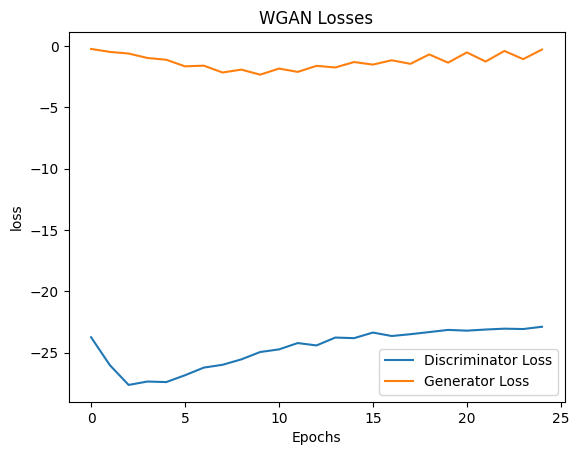

In [29]:
import matplotlib.pyplot as plt
print(steps)
plt.plot(Discriminator_loss)
plt.plot(Generator_loss)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('WGAN Losses')
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show

In [30]:
G.eval()
data_left, data_right = get_sample_image(G, n_noise)
x = np.linspace(0, 4, num=1000)

In [31]:
#choose right and left
index_left = np.where(label == 0)[0][0]
index_right = np.where(label ==1)[0][0]

y_left = data[index_left, 0, :].squeeze()
y_right = data[index_right, 0,:].squeeze()


In [32]:
# sampling rate
sr = 250
# sampling interval
ts = 1.0/sr
t = np.arange(0,4,ts)
x = y_left

C:\Python Projects\venv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Python Projects\venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


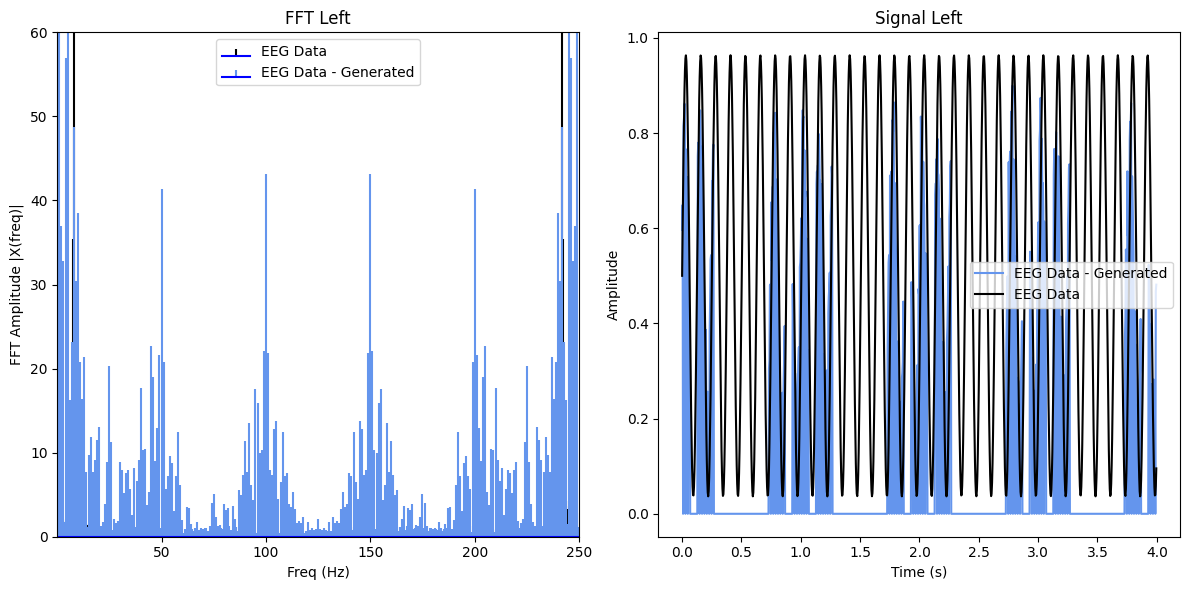

In [33]:


X_left = fft(y_left)
left_fft_gen = fft(data_left[0,:])
N = len(X_left)
n = np.arange(N)
T = N/sr
freq = n/T

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X_left), 'k', \
         markerfmt=" ", basefmt="-b", label='EEG Data')
plt.stem(freq, np.abs(left_fft_gen.squeeze()), 'cornflowerblue', \
         markerfmt=" ", basefmt="-b", label='EEG Data - Generated')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0.1, 250)
plt.title('FFT Left')
plt.legend()
plt.ylim(0, 60)

plt.subplot(122)
plt.plot(t, ifft(left_fft_gen.squeeze()), 'cornflowerblue', label='EEG Data - Generated')
plt.plot(t, ifft(X_left), 'k', label='EEG Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.title('Signal Left')
plt.legend()
plt.show()

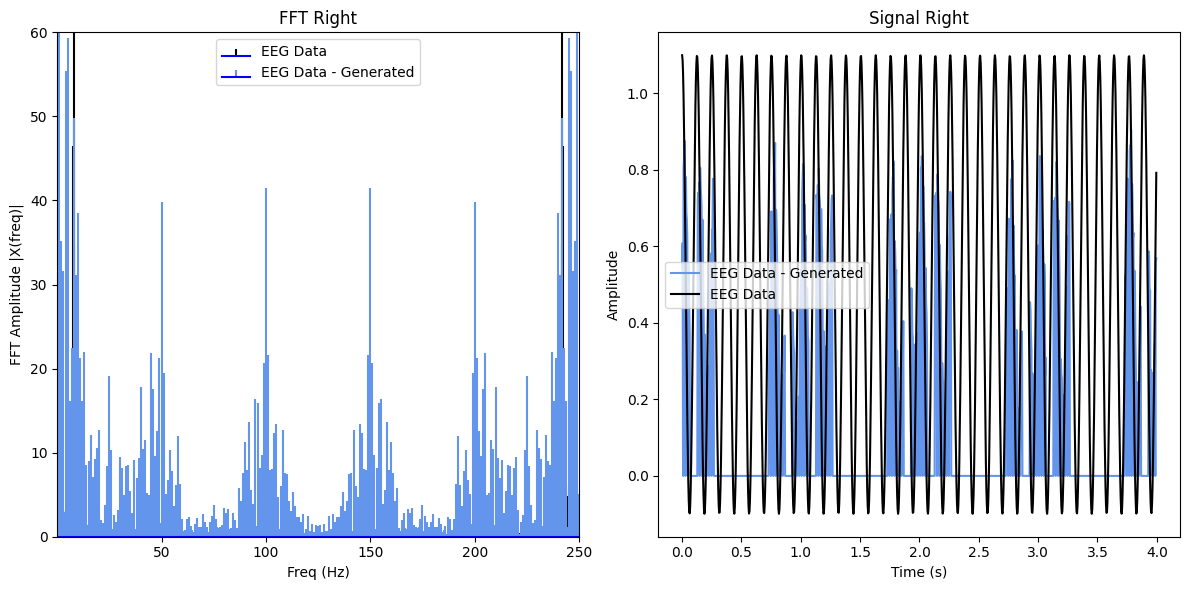

In [34]:
from numpy.fft import fft, ifft

X_right = fft(y_right)
right_fft_gen = fft(data_right[0,:])
N = len(X_right)
n = np.arange(N)
T = N/sr
freq = n/T

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X_right), 'k', \
         markerfmt=" ", basefmt="-b", label='EEG Data')
plt.stem(freq, np.abs(right_fft_gen.squeeze()), 'cornflowerblue', \
         markerfmt=" ", basefmt="-b", label='EEG Data - Generated')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0.1, 250)
plt.title('FFT Right')
plt.legend()
plt.ylim(0, 60)

plt.subplot(122)
plt.plot(t, ifft(right_fft_gen.squeeze()), 'cornflowerblue', label='EEG Data - Generated')
plt.plot(t, ifft(X_right), 'k', label='EEG Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.title('Signal Right')
plt.legend()
plt.show()